In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D,Reshape,Conv2DTranspose,UpSampling2D
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.utils import plot_model
from keras.datasets import mnist
from keras.utils import to_categorical
import warnings as wn
wn.filterwarnings('ignore')
import os
import cv2 as cv

2023-09-25 23:08:59.645432: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-25 23:09:00.173384: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-25 23:09:01.952238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define the path to your text file
file_path = 'Images_dataset/CUB_200_2011/CUB_200_2011/bounding_boxes.txt'

# Initialize empty lists to store the data
bounding_boxes = []

# Read the text file and parse its contents
with open(file_path, 'r') as file:
    for line in file:
        _,x, y, w, h = map(float, line.strip().split())
        bounding_boxes.append([x, y, w, h])

# Convert the lists into numpy arrays

bounding_boxes_array = np.array(bounding_boxes).astype('int')


In [3]:
bounding_boxes_array.shape

(11788, 4)

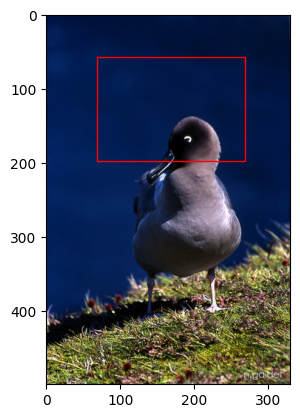

In [4]:
img = cv.imread('Images_dataset/CUB_200_2011/CUB_200_2011/images/003.Sooty_Albatross/Sooty_Albatross_0001_1071.jpg')
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
plt.imshow(img)
x, y, width, height = bounding_boxes_array[38]
plt.gca().add_patch(plt.Rectangle((x, y), width, height, fill=False, edgecolor='red'))
plt.show()

In [4]:
input_file = 'Images_dataset/CUB_200_2011/CUB_200_2011/images.txt'
output_file = 'Images_dataset/CUB_200_2011/CUB_200_2011/images_without_index.txt'

with open(input_file, 'r') as input_file:
    # Read all lines from the input file
    lines = input_file.readlines()

# Create an output file to write the modified lines
with open(output_file, 'w') as output_file:
    for line in lines:
        # Split the line by space into two parts
        parts = line.split(' ', 1)
        if len(parts) == 2:
            # Write only the second part (after the space) to the output file
            output_file.write(parts[1])

In [5]:
# Define the path to your text file
file_path = 'Images_dataset/CUB_200_2011/CUB_200_2011/images_without_index.txt'

# Initialize an empty list to store the data
image_names = []

# Read the text file and parse its contents
with open(file_path, 'r') as file:
    for line in file:
        # Remove leading/trailing whitespace and remove quotes, then split by commas
        image_name = line.strip().strip("'")
        image_names.append(image_name)

# Now, image_names will contain the image file names without quotes and commas


In [6]:
image_names[38]

'001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg'

In [7]:
def resize_bbox(bbox, old_shape, new_shape):
    x, y, w, h = bbox
    old_height, old_width = old_shape
    new_height, new_width = new_shape
    x = x * (new_width / old_width)
    y = y * (new_height / old_height)
    w = w * (new_width / old_width)
    h = h * (new_height / old_height)
    return [x, y, w, h]

In [8]:
def get_image_by_filename(folder_path, image_filename):

    image_path = os.path.join(folder_path, image_filename)

    try:
        image = cv.imread(image_path)
        image = cv.cvtColor(image,cv.COLOR_BGR2RGB)
        return np.round((image/255),2)
    except Exception as e:
        print(f"Error loading image '{image_filename}': {e}")
        return None


In [9]:
true_images = []
changed_bbox = []
#imgForBbx = []

folder_path = 'Images_dataset/CUB_200_2011/CUB_200_2011/images/'

for j in range(10):
    i = np.random.randint(4000,11000)
    image_filename = image_names[i]
    image = get_image_by_filename(folder_path,image_filename)
    image_shape = image.shape[:-1]
    x, y, width, height = resize_bbox(bounding_boxes_array[i],image_shape,(100,100))
    #img_nw = cv.resize(image,(224,224))
    img_bbx = cv.resize(image,(100,100))
    #imgForBbx.append(img_bbx)
    true_images.append(img_bbx)
    changed_bbox.append([x,y,width,height])

In [11]:
len(true_images),len(changed_bbox)#len(imgForBbx)

(10, 10)

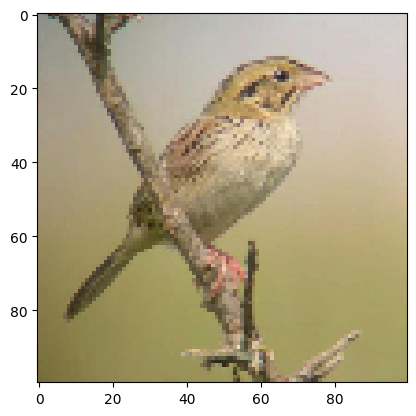

In [20]:
plt.imshow(true_images[6])

In [14]:
changed_bbox = np.array(changed_bbox)
true_images = np.array(true_images)

In [15]:
changed_bbox.shape,true_images.shape

((10, 4), (10, 100, 100, 3))

In [12]:
true_images.max()

1.0

In [13]:
w,l=100,100

In [18]:
model = tf.keras.Sequential([
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(w, l, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(456, activation='relu'),
    layers.Dense(156,activation='relu'),
    layers.Dense(4,activation='linear')  # Output layer with 4 units for (x, y, width, height)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 128)      

In [ ]:
model.fit(true_images,changed_bbox,epochs=20,batch_size=32)

Epoch 1/20
125/125 [==============================] - 80s 632ms/step - loss: 20.4660
Epoch 2/20
125/125 [==============================] - 86s 689ms/step - loss: 17.8629
Epoch 3/20
125/125 [==============================] - 89s 709ms/step - loss: 14.8651
Epoch 4/20
125/125 [==============================] - 88s 703ms/step - loss: 13.0443
Epoch 5/20
125/125 [==============================] - 90s 720ms/step - loss: 12.3912
Epoch 6/20
125/125 [==============================] - 88s 708ms/step - loss: 11.4941
Epoch 7/20
125/125 [==============================] - 88s 704ms/step - loss: 10.1526
Epoch 8/20
125/125 [==============================] - 91s 731ms/step - loss: 9.1181
Epoch 9/20
125/125 [==============================] - 85s 678ms/step - loss: 9.4075
Epoch 10/20
125/125 [==============================] - 85s 680ms/step - loss: 7.8547
Epoch 11/20
125/125 [==============================] - 90s 718ms/step - loss: 6.6661
Epoch 12/20
125/125 [==============================] - 91s 725ms/st

In [19]:
model.save('Trained_models/04_Caltch_birds_bbox.h5')

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 10, 10, 128)      

In [21]:
bbox = model.predict(true_images)

2023-09-17 14:39:08.170641: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 384000000 exceeds 10% of free system memory.


100/100 [==============================] - 14s 138ms/step


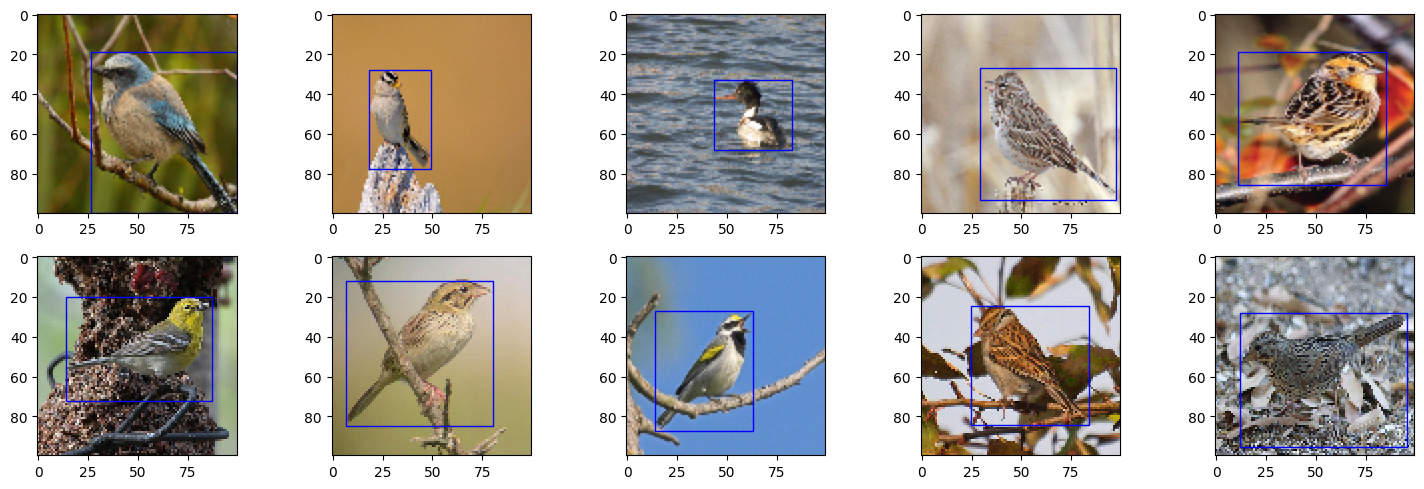

In [25]:
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    i = i
    #x, y, width, height = bbox[i]
    x1,y1,w1,h1 = changed_bbox[i]
    plt.imshow(true_images[i])
    #iou_score = calculate_iou(changed_bbox[i],bbox[i])
    #plt.gca().add_patch(plt.Rectangle((x, y), width, height, fill=False, edgecolor='red'))
    plt.gca().add_patch(plt.Rectangle((x1, y1), w1, h1, fill=False, edgecolor='blue'))
    #plt.title(f'IoU : {iou_score:.2f}')
    
plt.tight_layout()
plt.show()

In [22]:
def calculate_iou(box1, box2):
    # Extract coordinates of the boxes
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate the coordinates of the intersection rectangle
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    w_intersection = min(x1 + w1, x2 + w2) - x_intersection
    h_intersection = min(y1 + h1, y2 + h2) - y_intersection

    # Check if there is no intersection (one or both boxes have no area)
    if w_intersection <= 0 or h_intersection <= 0:
        return 0.0

    # Calculate the areas of the boxes and the intersection
    area1 = w1 * h1
    area2 = w2 * h2
    intersection = w_intersection * h_intersection

    # Calculate the IoU score
    iou = intersection / float(area1 + area2 - intersection)

    return iou

In [22]:
bbox

array([[ 48.809467,  49.23701 , 261.39456 , 341.86478 ],
       [ 78.0449  ,  40.562794, 169.37549 , 288.3694  ],
       [ 52.20288 , 117.490265, 282.06464 , 245.61693 ],
       [ 87.96127 ,  68.88118 , 207.01237 , 220.67189 ],
       [ 59.060413,  40.015347, 157.94955 , 252.30171 ],
       [ 35.668278,  64.76852 , 229.21983 , 304.1904  ],
       [ 56.963005,  92.23224 , 307.921   , 349.4885  ],
       [ 53.122578,  93.00343 , 256.56635 , 182.50685 ],
       [ 77.51703 ,  98.9757  , 233.49312 , 238.53859 ],
       [ 42.611065,  43.16214 , 284.1547  , 340.99448 ],
       [ 21.794842,  68.4523  , 317.2534  , 276.62784 ],
       [ 55.830757,  52.508507, 197.42043 , 297.47043 ],
       [ 50.90886 ,  43.731815, 256.5248  , 332.53748 ],
       [ 35.72189 ,  73.89338 , 272.7205  , 222.55612 ],
       [ 49.298084,  99.06593 , 299.8701  , 238.49315 ],
       [ 83.40523 , 104.34886 , 236.76591 , 255.07164 ],
       [ 53.046238,  42.54965 , 250.54716 , 247.77179 ],
       [ 43.543777,  72.27397 ,

In [31]:
lngth,wdth,_ = true_images[0].shape

In [37]:
b = resize_bbox(bbox[0],(lngth,wdth),(400,400))

In [36]:
b

[48.0, 32.23880597014925, 260.0, 362.98507462686564]

In [38]:
b

[45.97624588012695, 44.76203155517578, 283.1780700683594, 336.8910827636719]

In [3]:
model = load_model('Trained_models/04_Caltch_birds_bbox.h5')
model2 = load_model('Trained_models/02_Caltch_birds_bbox.h5')

In [16]:
img = cv.imread('/home/junaidulhassan/Pictures/Screenshots/Screenshot from 2023-09-25 23-14-04.png')
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
img = cv.resize(img,(100,100))
img = img/255
imgs = img.reshape(1,100,100,3)

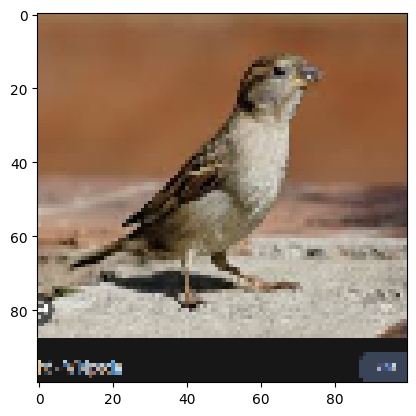

In [17]:
plt.imshow(img)

In [20]:
b = model2.predict(imgs)

1/1 [==============================] - 0s 30ms/step


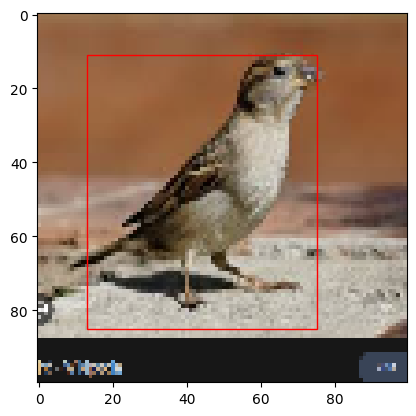

In [21]:
x, y, width, height = b[0]
plt.imshow(img)
plt.gca().add_patch(plt.Rectangle((x, y), width, height, fill=False, edgecolor='red'))

### Classification and bbox

In [20]:
changed_bbox = np.array(changed_bbox)
true_images = np.array(true_images)
imgForBbx = np.array(imgForBbx)

In [21]:
imgForBbx.shape

(210, 100, 100, 3)

In [2]:
classifier = load_model('Trained_models/Caltch_birds_classifier.h5')
bbox_pred = load_model('Trained_models/04_Caltch_birds_bbox.h5')

In [23]:
class_pred = classifier.predict(true_images)
bbx_pred = bbox_pred.predict(imgForBbx)

2023-09-24 20:53:33.775553: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 126443520 exceeds 10% of free system memory.
2023-09-24 20:53:34.348520: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2023-09-24 20:53:34.395381: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2023-09-24 20:53:34.431837: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2023-09-24 20:53:34.460845: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


7/7 [==============================] - 1s 162ms/step


In [24]:
bbx_pred.shape,class_pred.shape

((210, 4), (210, 200))

In [25]:
class_pred = np.argmax(class_pred,axis=1)

In [26]:
train_dir = 'Images_dataset/CUB_200_2011/CUB_200_2011/images/'
train_gen = ImageDataGenerator(
    rescale=1./255
)
train_df = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True
)

Found 11788 images belonging to 200 classes.


In [27]:
labels = train_df.class_indices

In [28]:
def get_bird_name(number):
    for name, value in labels.items():
        if value == number:
            # Remove the starting number and replace underscores with spaces
            return name.split('.', 1)[1].replace('_', ' ')
    return None

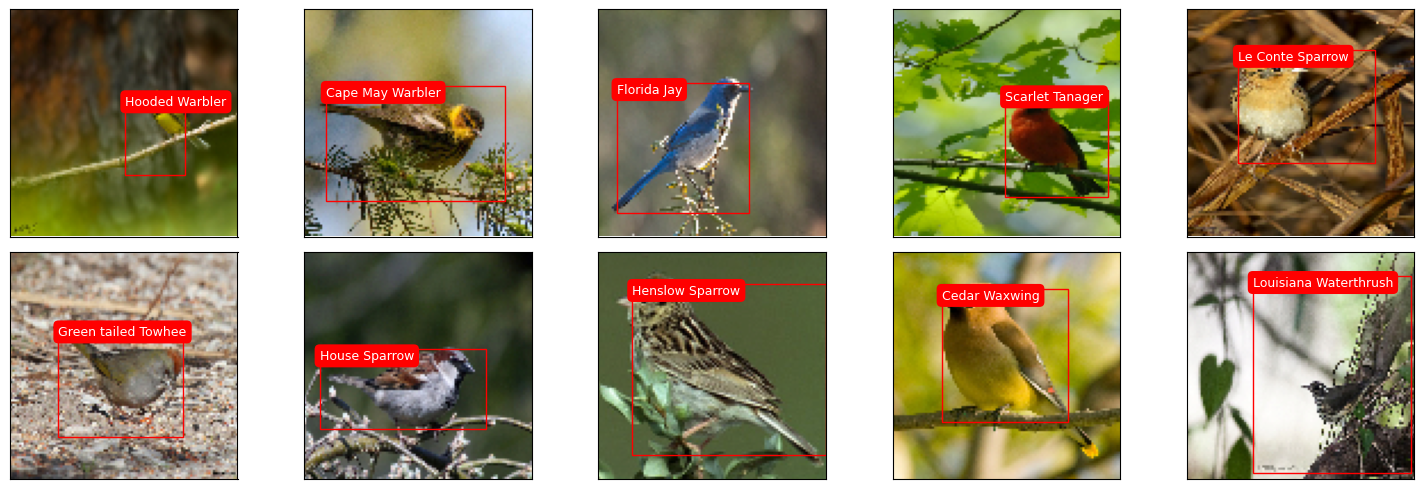

In [29]:
plt.figure(figsize=(15,5))
for i in range(10):
    ax = plt.subplot(2,5, i + 1)
    i = i*11
    x, y, width, height = bbx_pred[i]
    num = class_pred[i]
    img = imgForBbx[i]
    cls = get_bird_name(num)

    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    #plt.title(cls)

    plt.imshow(img)
    plt.gca().add_patch(plt.Rectangle((x, y), width, height, fill=False, edgecolor='red'))
    label = f"{cls}"
    plt.text(x, y - 0.03, label, color='white', fontsize=9, verticalalignment='top', bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.4'))

plt.tight_layout()
plt.show()
